# Monet CycleGAN - IA Project
#### ***AI Project***
> #### Project Made By ***Youssef Khammassi & Safa Abdeljabbar - II3 IA***

---


This notebook utilizes a CycleGAN architecture to add Monet-style to photos.

We can create Monets with Generative Adversarial Networks (GAN) in a few different ways. We can generate them from scratch using one GAN, where the GAN basically imagines a Monet from scratch. GANs are technically two networks that work against each other, illustrated below. The artist (generator) draws its inspiration from a noise sample and creates a rendering of the data you are trying to generate with said GAN. The private investigator (discriminator) randomly gets assigned real and fake data to investigate. 

In this Project we worked on:

- Data Augmentation
- Neural Network Architectures
- CycleGAN architectures
- Better Loss functions

The main idea behind a CycleGAN is that two Generative Adversarial Networks are trained. Network one learning the forward transformation to the target domain and the second network learning the inverse transformation back to the original image domain. Pairing this with the GAN loss of creating "believable" images, at least according to the discriminator of the GAN, yields some surprisingly good transformations.

## Introduction and Setup

we will be using the TFRecord dataset. Import the following packages and change the accelerator to TPU. 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE

print(tf.__version__)

Device: grpc://10.0.0.2:8470
Number of replicas: 8
2.2.0


# Load in the data

All the images are already sized to `256 x 256`. As these images are RGB images, set the channel to 3. Additionally, we scale the images to a `[-1, 1]` scale.

In [ ]:
GCS_PATH = KaggleDatasets().get_gcs_path()

MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


we did the **data augmentation** using `random_jitter` and `flip` to increase our data set, because we simply don't have enough data for Training

In [ ]:
IMAGE_SIZE = [256, 256]

def decode(img):
    image = tf.image.decode_jpeg(img, channels=3)
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def normalize(img):
    return (tf.cast(img, tf.float32) / 127.5) - 1

def flip(img):
    return tf.image.flip_left_right(img)

def random_crop(img):
    cropped_image = tf.image.random_crop(img, size=[256, 256, 3])
    return cropped_image

def random_jitter(img):
    image = tf.image.resize(img, [int(256*1.3), int(256*1.3)],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    image = random_crop(image)
    return image

def preprocess_image_train(img, label=None):
    image = random_jitter(img)
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode(example['image'])
    return image

def load_dataset(filenames, labeled=False, ordered=False, repeats=200):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    dataset = dataset.concatenate(dataset.map(flip, num_parallel_calls=AUTOTUNE).shuffle(100000))
    dataset = dataset.concatenate(dataset.map(random_jitter, num_parallel_calls=AUTOTUNE).shuffle(10000, reshuffle_each_iteration=True).repeat(repeats))
    dataset = dataset.map(normalize, num_parallel_calls=AUTOTUNE).shuffle(10000)
    return dataset

In [ ]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True, repeats=50).batch(100, drop_remainder=True)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True, repeats=2  ).batch(100, drop_remainder=True)

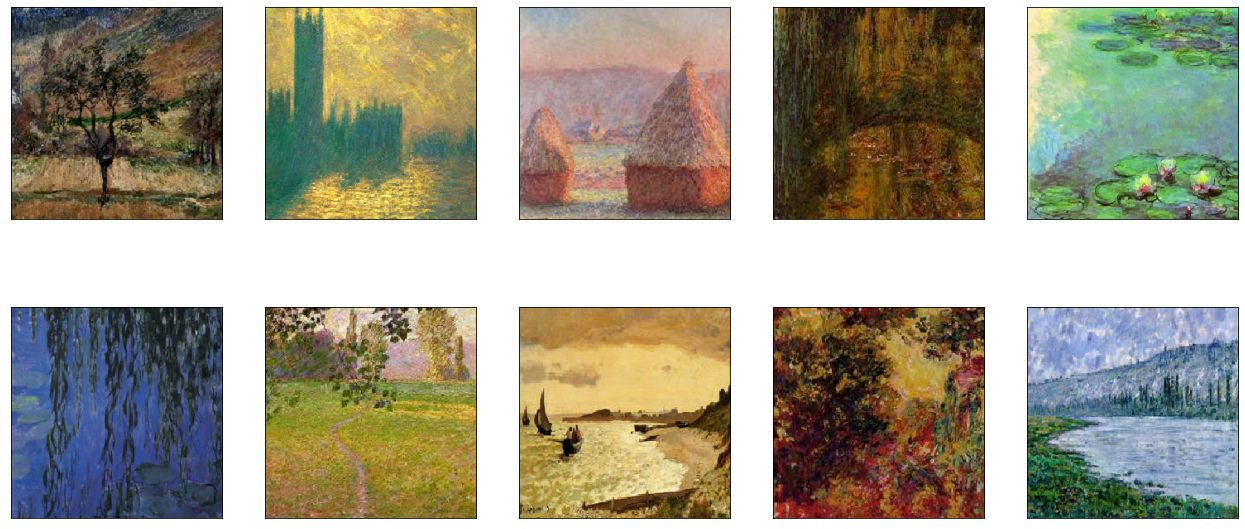

In [ ]:
def view_image(ds, rows=2):
    image = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()

    fig = plt.figure(figsize=(22, rows * 5.05 ))
    for i in range(5 * rows):
        ax = fig.add_subplot(rows, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i] / 2 + .5)

view_image(monet_ds)

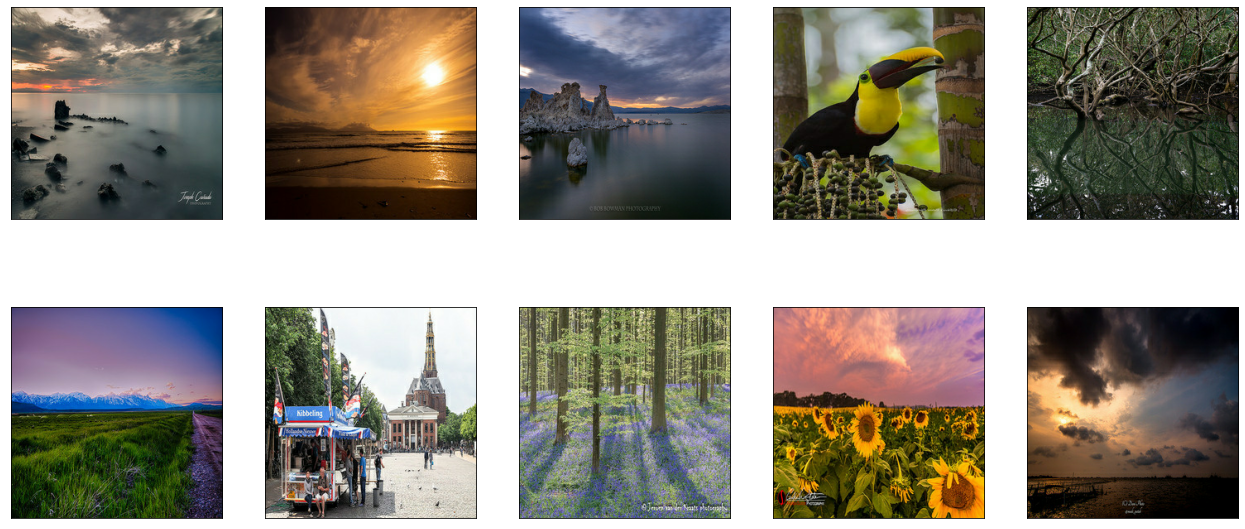

In [ ]:
view_image(photo_ds)

# Building the DCGAN ( Deep Convolutional Generative Adversarial Networks )
## Network Upsample and Downsample

The `downsample`, as the name suggests, reduces the 2D dimensions, the width and height, of the image by the stride. The stride is the length of the step the filter takes. Since the stride is 2, the filter is applied to every other pixel, hence reducing the weight and height by 2.

We'll be using an instance normalization instead of batch normalization. As the instance normalization is not standard in the TensorFlow API, we'll use the layer from TensorFlow Add-ons.

In [ ]:
OUTPUT_CHANNELS = 3
LATENT_DIM = 1024

def downsampling(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    r = keras.Sequential()
    r.add(layers.Conv2D(filters, size, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    r.add(layers.MaxPool2D())

    if apply_instancenorm:
        r.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    r.add(layers.LeakyReLU())

    return r

`Upsample` does the opposite of downsample and increases the dimensions of the of the image. `Conv2DTranspose` does basically the opposite of a `Conv2D` layer.

In [ ]:
def upsampling(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    r = keras.Sequential()
    r.add(layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        r.add(layers.Dropout(0.5))

    r.add(layers.LeakyReLU())

    return result

## Build Network
The generator first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion. Unets are pretty versatile and help out in our Generator to distill the input image to a lower dimension and then back to the full size at the target.

![](https://i.imgur.com/7GE9nY1.png)
[Source](https://github.com/HarisIqbal88/PlotNeuralNet)

In [ ]:
EPOCHS = 25

LR_G = 2e-4
LR_D = 2e-4
beta_1 = .5

real_label = .9
fake_label = 0

**The generator** first downsamples the input image and then upsample while establishing long skip connections. Skip connections are a way to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one. Here we concatenate the output of the downsample layer to the upsample layer in a symmetrical fashion.

In [ ]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    downstack = [
        downsampling(64, 4, apply_instancenorm=False),
        downsampling(128, 4), 
        downsampling(256, 4), 
        downsampling(512, 4), 
        downsampling(512, 4), 
        downsampling(512, 4), 
        downsampling(512, 4), 
        downsampling(512, 4), 
    ]

    upstack = [
        upsampling(512, 4, apply_dropout=True), 
        upsampling(512, 4, apply_dropout=True), 
        upsampling(512, 4, apply_dropout=True), 
        upsampling(512, 4), 
        upsampling(256, 4), 
        upsampling(128, 4), 
        upsampling(64, 4), 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    s = []
    for d in downstack:
        x = d(x)
        s.append(x)

    s = reversed(s[:-1])

    # Upsampling and establishing the skip connections
    for up, i in zip(upstack, s):
        x = up(x)
        x = layers.Concatenate()([x, i])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminator does not need a Unet, just a nice simple downsample to get a simple `fake` or `real` represented in numbers.

In [ ]:
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    d1 = downsampling(64, 4, False)(x) 
    d2 = downsampling(128, 4)(d1)
    d3 = downsampling(256, 4)(d2) 

    zero_pad1 = layers.ZeroPadding2D()(3) 
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) 

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) 

    last_conv = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    last_relu = layers.LeakyReLU(alpha=0.2)(last_conv)
    last_pool = layers.Flatten()(last_relu)
    last = layers.Dense(1, activation='sigmoid')(last_pool)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
with strategy.scope():
    monet_CycleGenerator = generator() 
    monet_CycleDiscriminator = discriminator()
    
    photo_CycleGenerator = generator() 
    photo_CycleDiscriminator = discriminator() 

## Build the CycleGAN model

During the training step, the model transforms a photo to a Monet painting and then back to a photo. The difference between the original photo and the twice-transformed photo is the cycle-consistency loss. 

this works is by having one GAN for the forwards transformation and one GAN for the backwards transformation. So from image domain $X \rightarrow Y$ and backwards $Y \rightarrow X$. The resulting images are each evaluated by the standard discriminators of the GANs.
![](https://i.imgur.com/05Cjt6e.png)


In [ ]:
class CycleGan(keras.Model):
    def __init__(self,monetG,photoG,monetD,photoD,lambda_cycle=10,Rlabel=.5):
        super(CycleGan, self).__init__()
        self.m_gen = monetG
        self.p_gen = photoG
        self.m_disc = monetD
        self.p_disc = photoD
        self.lambda_cycle = lambda_cycle
        self.Rlabel = Rlabel
        
    def compile(self,m_gen_optimizer,p_gen_optimizer,m_disc_optimizer,p_disc_optimizer,gen_loss_fn,disc_loss_fn,cycle_loss_fn,identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        realMonet, realPhoto = batch_data
        
        batch_size = tf.shape(realPphoto)[0]
        labels_real = tf.zeros((batch_size, 1)) + self.Rlabel
        labels_real += 0.05 * tf.random.uniform(tf.shape(labels_real))        
        
        with tf.GradientTape(persistent=True) as tape:
            fakeMonet = self.m_gen(reaPhoto, training=True)
            cycled_photo = self.p_gen(fakeMonet, training=True)

            
            fakePhoto = self.p_gen(realMonet, training=True)
            cycledMonet = self.m_gen(fakePhoto, training=True)

            
            same_monet = self.m_gen(realMonet, training=True)
            same_photo = self.p_gen(realPhoto, training=True)

            
            disc_real_monet = self.m_disc(realMonet, training=True)
            disc_real_photo = self.p_disc(realPhoto, training=True)

            
            disc_fake_monet = self.m_disc(fakeMonet, training=True)
            disc_fake_photo = self.p_disc(fakePhoto, training=True)

            
            monet_gen_loss = self.gen_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_gen_loss = self.gen_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

            
            total_cycle_loss = self.cycle_loss_fn(realMonet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(realPhoto, cycled_photo, self.lambda_cycle)

            
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(realMonet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(realPhoto, same_photo, self.lambda_cycle)

            
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet, labels_real)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo, labels_real)

        
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

> ## Loss functions

The discriminator loss function below compares real images to a matrix of 1s and fake images to a matrix of 0s. The perfect discriminator will output all 1s for real images and all 0s for fake images. The discriminator loss outputs the average of the real and generated loss.

The generator wants to fool the discriminator into thinking the generated image is real. The perfect generator will have the discriminator output only 1s. Thus, it compares the generated image to a matrix of 1s to find the loss.

In [ ]:
with strategy.scope():
    def discriminator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) + labels_real) ** 2) +
                tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  - labels_real) ** 2))/2
    
    def generator_loss(predictions_real, predictions_gen, labels_real):
        return (tf.reduce_mean((predictions_real - tf.reduce_mean(predictions_gen)  + labels_real) ** 2) +
                tf.reduce_mean((predictions_gen  - tf.reduce_mean(predictions_real) - labels_real) ** 2)) / 2

## More Loss Functions
We want our original photo and the twice transformed photo to be similar to one another. Thus, we can calculate the cycle consistency loss be finding the average of their difference.

In [ ]:
with strategy.scope():
    def calc_cycle_loss(real_image, cycled_image, LAMBDA):
        loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

        return LAMBDA * loss1

The identity loss compares the image with its generator (i.e. photo with photo generator). If given a photo as input, we want it to generate the same image as the image was originally a photo. The identity loss compares the input with the output of the generator.

In [ ]:
with x:
    def identity_loss(real_image, same_image, LAMBDA):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return LAMBDA * 0.5 * loss

# Training the CycleGAN

In [ ]:
with strategy.scope():
    monet_generator_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)
    photo_generator_optimizer = tf.keras.optimizers.Adam(LR_G, beta_1=0.5)

    monet_discriminator_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)
    photo_discriminator_optimizer = tf.keras.optimizers.Adam(LR_D, beta_1=0.5)

In [ ]:
with strategy.scope():
    cycle_gan_model = CycleGan(
        monet_cycle_generator, photo_cycle_generator, monet_cycle_discriminator, photo_cycle_discriminator, real_label=0.66
    )

    cycle_gan_model.compile(
        m_gen_optimizer = monet_generator_optimizer,
        p_gen_optimizer = photo_generator_optimizer,
        m_disc_optimizer = monet_discriminator_optimizer,
        p_disc_optimizer = photo_discriminator_optimizer,
        gen_loss_fn = generator_loss,
        disc_loss_fn = discriminator_loss,
        cycle_loss_fn = calc_cycle_loss,
        identity_loss_fn = identity_loss
    )

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_ds, photo_ds)),
    epochs=EPOCHS
)

Epoch 1/25
306/306 [==============================] - 161s 527ms/step - photo_disc_loss: 0.0697 - photo_gen_loss: 5.9417 - monet_disc_loss: 0.1426 - monet_gen_loss: 5.6049
Epoch 2/25
306/306 [==============================] - 161s 525ms/step - photo_disc_loss: 0.1325 - photo_gen_loss: 4.6458 - monet_disc_loss: 0.1647 - monet_gen_loss: 4.5367
Epoch 3/25
306/306 [==============================] - 161s 526ms/step - photo_disc_loss: 0.0801 - photo_gen_loss: 4.7083 - monet_disc_loss: 0.1598 - monet_gen_loss: 4.4141
Epoch 4/25
306/306 [==============================] - 161s 525ms/step - photo_disc_loss: 0.0757 - photo_gen_loss: 4.5071 - monet_disc_loss: 0.1464 - monet_gen_loss: 4.2098
Epoch 5/25
306/306 [==============================] - 161s 525ms/step - photo_disc_loss: 0.0699 - photo_gen_loss: 4.3805 - monet_disc_loss: 0.1146 - monet_gen_loss: 4.1377
Epoch 6/25
306/306 [==============================] - 160s 524ms/step - photo_disc_loss: 0.0748 - photo_gen_loss: 4.3328 - monet_disc_loss: 

# Visualize Monet-esque photos

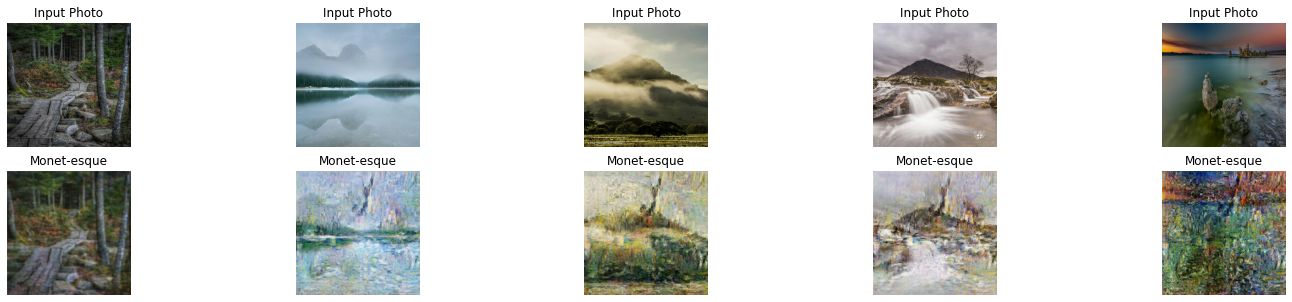

In [ ]:
_, ax = plt.subplots(2, 5, figsize=(25, 5))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_cycle_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[0, i].imshow(img)
    ax[1, i].imshow(prediction)
    ax[0, i].set_title("Input Photo")
    ax[1, i].set_title("Monet-esque")
    ax[0, i].axis("off")
    ax[1, i].axis("off")
plt.show()